## Global configuration

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import os

# Select CPU or GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # "0"


## Data loading and preparation

In [ ]:
from sklearn import datasets

# Load data
housing_dataset = datasets.fetch_california_housing(as_frame=True)

n_samples = 10000

# Get features and targets
features = housing_dataset.data[:n_samples]
target = housing_dataset.target[:n_samples]

# Normalize features
features = (features - features.mean()) / (features.std())


## Define models, predictors and CP procedures

In [ ]:
# Keras NN Split CP
from tensorflow.keras import Sequential, layers, optimizers
from deel.puncc.api.calibration import BaseCalibrator

nn = Sequential()
nn.add(layers.Dense(20, activation="relu"))
nn.add(layers.Dense(1))
compile_kwargs = {
    "optimizer": optimizers.legacy.Adam(learning_rate=1e-3),
    "loss": "mse",
}

# Wrap model in a predictor
keras_nn_predictor = BasePredictor(nn, **compile_kwargs)

# CP procedure
splitcp_nn_keras = SplitCP(keras_nn_predictor, random_state=0)


In [ ]:
# Torch NN Split CP
import torch
from deel.puncc.api.experimental import TorchPredictor


class LinearTorchModel(torch.nn.Module):
    def __init__(self, input_feat, output_feat):
        super(LinearTorchModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_feat, 20)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(20, output_feat)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out


torch_model = LinearTorchModel(features.shape[-1], 1)
compile_kwargs = {"lr": 1e-3}

# Wrap model in a predictor
torch_nn_predictor = TorchPredictor(
    torch_model, optimizer=torch.optim.RMSprop, **compile_kwargs
)

# CP procedure
splitcp_nn_torch = SplitCP(torch_nn_predictor, random_state=0)


In [ ]:
# XGBOOST/KNN LACP
from xgboost import XGBRegressor
from sklearn import neighbors

xgb = XGBRegressor(n_estimators=100)
sigma_model = neighbors.KNeighborsRegressor(n_neighbors=5, weights="uniform")
xgb_predictor = DualPredictor([xgb, sigma_model], is_trained=[False, False])
lacp_xgb = LocallyAdaptiveCP(xgb_predictor, random_state=0)


In [ ]:
# CQR/CV+ GradBoost
from sklearn.ensemble import GradientBoostingRegressor
from deel.puncc.api.nonconformity_scores import cqr_score
from deel.puncc.api.prediction_sets import cqr_interval
from deel.puncc.api.splitting import KFoldSplitter
from deel.puncc.api.conformalization import ConformalPredictor

# Lower quantile regressor
regressor_q_low = GradientBoostingRegressor(
    loss="quantile", alpha=0.2 / 2, n_estimators=250
)
# Upper quantile regressor
regressor_q_hi = GradientBoostingRegressor(
    loss="quantile", alpha=1 - 0.2 / 2, n_estimators=250
)

# Wrap models in predictor
gb_predictor = DualPredictor(models=[regressor_q_low, regressor_q_hi])

# Define a calibrator from the API
calibrator = BaseCalibrator(
    nonconf_score_func=cqr_score, pred_set_func=cqr_interval
)

# Define a splitter from the API
splitter = KFoldSplitter(K=10, random_state=0)

# Assemble the predictor/calibrator/splitter in
# a conformal predictor canvas
cvp_gb = ConformalPredictor(
    predictor=gb_predictor, calibrator=calibrator, splitter=splitter
)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

from deel.puncc.api.prediction import BasePredictor, DualPredictor
from deel.puncc.regression import SplitCP, LocallyAdaptiveCP, CVPlus
from deel.puncc.metrics import regression_mean_coverage, regression_sharpness


results = []
experiment_count = 0

# Values of alpha to experiment with
alphas = np.arange(0.1, 1, 0.1)

conformal_predictors = {
    "Split CP -- NN (Keras)": splitcp_nn_keras,
    "Split CP -- NN (Torch)": splitcp_nn_torch,
    "LACP -- KNN/xgboost (sklearn/XGBOOST)": lacp_xgb,
    "CV+ -- Gradboost (sklearn)": cvp_gb,
}


# Experiments are replicated and average across 20 random folds
kfold = KFold(n_splits=20, shuffle=True, random_state=0)

for train_idx, test_idx in tqdm(kfold.split(features)):
    # Get train and test data
    X_train, y_train = features.iloc[train_idx], target.iloc[train_idx]
    X_test, y_test = features.iloc[test_idx], target.iloc[test_idx]

    # Preprocess data (standardization)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit, predict and compute metrics for each CP procedure
    for cp_name, conformal_predictor in conformal_predictors.items():
        if "Torch" in cp_name:
            X_train_torch = torch.tensor(X_train, dtype=torch.float32)
            y_train_torch = torch.tensor(
                y_train.values[..., np.newaxis], dtype=torch.float32
            )
            conformal_predictor.fit(
                X=X_train_torch, y=y_train_torch, **{"epochs": 150}
            )
        else:
            if "Keras" in cp_name:
                conformal_predictor.fit(X=X_train, y=y_train, **{"epochs": 20})
            conformal_predictor.fit(X=X_train, y=y_train)
        for alpha in alphas:
            if "Torch" in cp_name:
                X_test_torch = torch.tensor(X_test, dtype=torch.float32)
                y_test_torch = torch.tensor(
                    y_test.values[..., np.newaxis], dtype=torch.float32
                )
                (
                    y_pred,
                    y_pred_lower,
                    y_pred_upper,
                ) = conformal_predictor.predict(X_test_torch, alpha=alpha)
                coverage = regression_mean_coverage(
                    y_test_torch.detach().numpy(),
                    y_pred_lower.detach().numpy(),
                    y_pred_upper.detach().numpy(),
                )
                width = regression_sharpness(
                    y_pred_lower=y_pred_lower.detach().numpy(),
                    y_pred_upper=y_pred_upper.detach().numpy(),
                )
            else:
                (
                    y_pred,
                    y_pred_lower,
                    y_pred_upper,
                ) = conformal_predictor.predict(X_test, alpha=alpha)
                coverage = regression_mean_coverage(
                    y_test, y_pred_lower, y_pred_upper
                )
                width = regression_sharpness(
                    y_pred_lower=y_pred_lower, y_pred_upper=y_pred_upper
                )

            results.append([cp_name, experiment_count, alpha, coverage, width])

    experiment_count += 1

columns = ["method", "experiment", "alpha", "coverage", "width"]
results_df = pd.DataFrame(results, columns=columns)

with open("results/results_regression_california.pickle", "wb") as output_file:
    pickle.dump(results_df, output_file)


## Results

In [2]:
with open("results/results_regression_california.pickle", "rb") as input_file:
    results_df = pickle.load(input_file)

# Add ace metrics: columns = ["method", "experiment", "alpha", "coverage", "width", "ace"]
results_df["ace"] = abs(results_df["coverage"] - 1 + results_df["alpha"])

# Compute mean and std per alpha and method
group = results_df.groupby(["alpha","method"])
filter = ["ace", "coverage", "width"]
rename_mean = {"ace": "mean ace", "coverage":"mean coverage", "width": "mean width"}
rename_std = {"ace": "std ace", "coverage":"std coverage", "width": "std width"}
mean = group.mean()[filter].rename(columns=rename_mean).round(2)
std = group.std()[filter].rename(columns=rename_std).round(3)

#columns = ["method", "alpha", "mean coverage", "mean width", "mean ace", "std coverage", "std width", "std ace"]
results_mean_std = mean.join(std, on=["alpha", "method"]).reset_index() 

#columns = ["method", "mean coverage", "mean width", "mean ace", "std coverage", "std width", "std ace"]
results_per_method = results_mean_std.groupby("method").mean() 

filter = []
for metric in ("ace", "width"):
    results_per_method[f"mean {metric}"] = results_per_method[f"mean {metric}"].round(2)
    results_per_method[f"std {metric}"] = results_per_method[f"std {metric}"].round(3)
    results_per_method[f"Mean {metric} ± std"] = results_per_method[f"mean {metric}"].astype(str) + " ± " + results_per_method[f"std {metric}"].astype(str)
    filter.append(f"Mean {metric} ± std")

#columns = ["method", "mean width ± std"", "mean ace ± std""]
results_per_method[filter]

,Mean ace ± std,Mean width ± std
method,,
CV+ -- Gradboost (sklearn),0.02 ± 0.012,0.8 ± 0.027
LACP -- KNN/xgboost (sklearn/XGBOOST),0.02 ± 0.01,0.62 ± 0.018
Split CP -- NN (Keras),0.02 ± 0.011,1.14 ± 0.093
Split CP -- NN (Torch),0.02 ± 0.011,1.22 ± 0.025


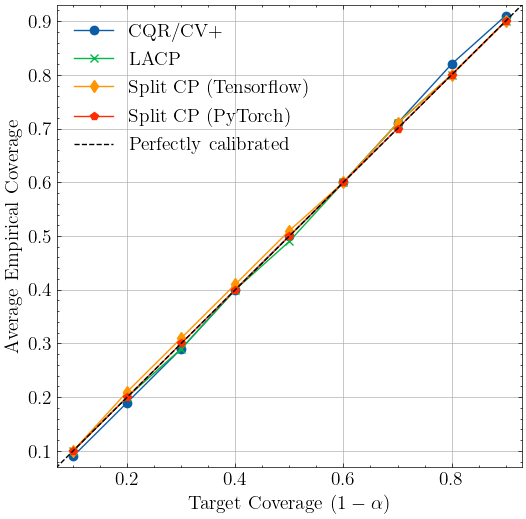

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
%matplotlib inline

import scienceplots

plt.style.use('science')

alphas = np.arange(.1, 1, .1)

markers = ["-o", "-x", "-d", "-p"]

fig, ax = plt.subplots(figsize=(6,6))

labels = ["CQR/CV+", "LACP", "Split CP (Tensorflow)", "Split CP (PyTorch)"]

for i, method in enumerate(results_mean_std["method"].unique()):
    filter = results_mean_std["method"] == method
    ax.plot(1-results_mean_std[filter]["alpha"], results_mean_std[filter]["mean coverage"], markers[i], label=labels[i])

ax.plot(np.arange(0,1.1,.1), np.arange(0,1.1,.1), "--", c="k", label="Perfectly calibrated", markersize=5)

ax.set_xlabel(r"Target Coverage ($1-\alpha$)")
ax.set_ylabel(r"Average Empirical Coverage")

ax.set_xlim([0.07,.93])
ax.set_ylim([0.07,.93])

ax.grid(True)

plt.legend()

plt.savefig("regression_coverage_california.pdf")


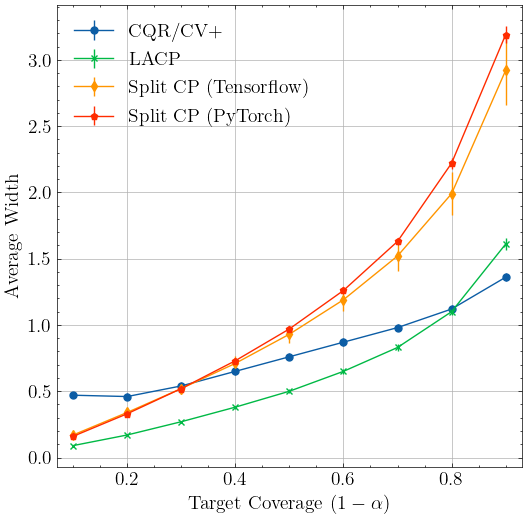

In [4]:
markers = ["-o", "-x", "-d", "-p"]
labels = ["CQR/CV+", "LACP", "Split CP (Tensorflow)", "Split CP (PyTorch)"]

fig, ax = plt.subplots(figsize=(6,6))

for i, method in enumerate(results_mean_std["method"].unique()):
    filter = results_mean_std["method"] == method
    x = 1-results_mean_std[filter]["alpha"]
    y = results_mean_std[filter]["mean width"]
    e = results_mean_std[filter]["std width"]
    ax.errorbar(x, y, yerr=e, fmt=markers[i], markersize=5, label=labels[i])

ax.set_xlabel(r"Target Coverage ($1-\alpha$)")
ax.set_ylabel(r"Average Width")

ax.set_xlim([0.07,.93])

plt.grid()
plt.legend()

plt.savefig("regression_width_california.pdf")
